In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff 

#Funções de avaliação dos modelos
from sklearn.metrics import (
    classification_report,
    plot_confusion_matrix,
    plot_roc_curve,
    accuracy_score,
)
from sklearn.model_selection import(
    train_test_split, 
    cross_val_predict,
    KFold,
)

#utils
from utils.num import Num
from utils.run_models import RunModels

import warnings
warnings.filterwarnings('ignore')

In [15]:
#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import svm

In [16]:
raw_data = loadarff('mnist_784.arff')
df = pd.DataFrame(raw_data[0])

<BarContainer object of 10 artists>

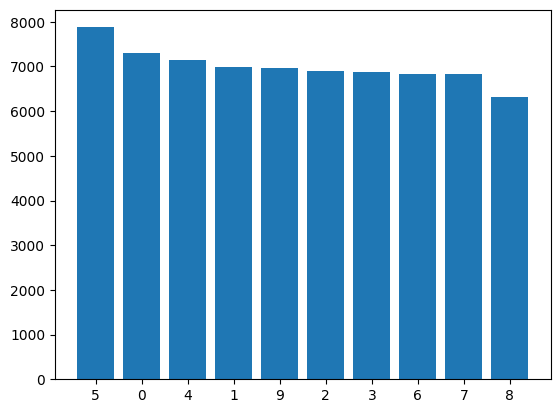

In [17]:
plt.bar(x = df['class'].unique(), height = df['class'].value_counts())

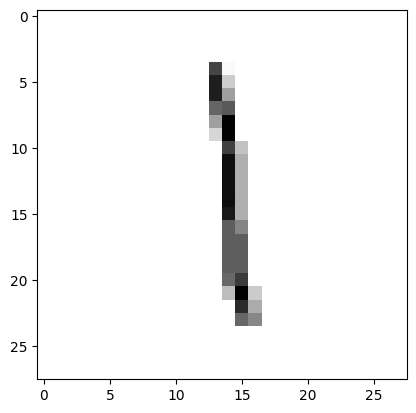

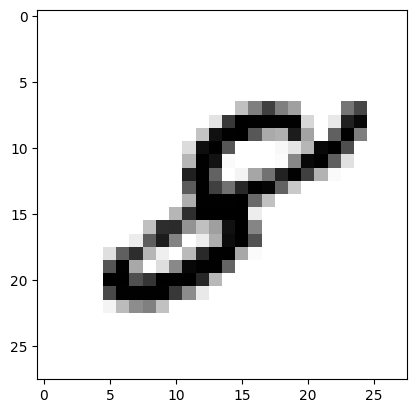

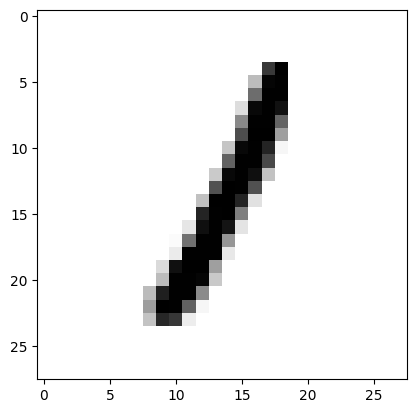

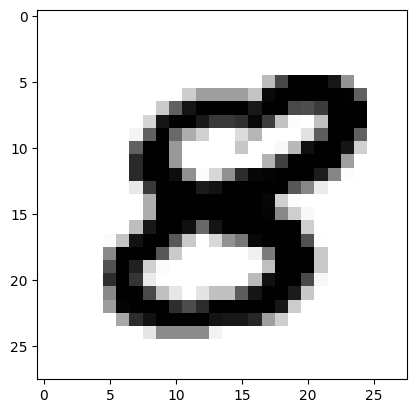

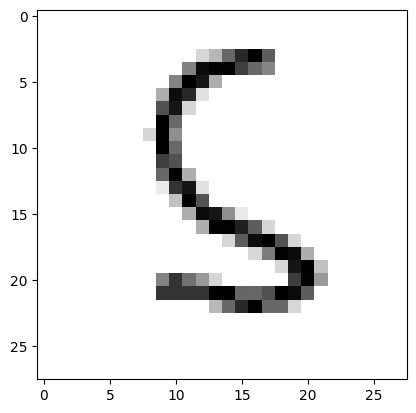

In [24]:
# Visualizando algumas instância do dataset

nums = df['class'].unique()

for i in np.random.randint(1000, size=5):
    rnd_choice = np.random.choice(nums)
    p = pd.array(
        df[df['class'] == rnd_choice].iloc[i][:-1],
        dtype=int,
    ).reshape((28,28))

    plt.imshow(p, cmap='gray_r', vmin=0, vmax=255)
    plt.show()

In [31]:
# Separando dataset

X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

kf = KFold(n_splits=5)
fold = 0

# Treinando os modelos

run = RunModels(
    {
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        # 'GaussianNB': GaussianNB(),
        'MultinomialNB': MultinomialNB(),
        # 'Perceptron': Perceptron(),
        # 'MLP': MLPClassifier(),
        # 'SVM': svm.SVC(),
    }
)

for train, test in kf.split(X,y):
    run.load_data(X.iloc[train], X.iloc[test],
                  y.iloc[train], y.iloc[test])
    run.train()

    print(f'Fold {fold}: {run.accuracy()}')
    fold += 1

Fold 0: {'KNN': 0.9699285714285715, 'Decision Tree': 0.8721428571428571, 'MultinomialNB': 0.8215}
Fold 1: {'KNN': 0.9709285714285715, 'Decision Tree': 0.8727857142857143, 'MultinomialNB': 0.8169285714285714}
Fold 2: {'KNN': 0.9707142857142858, 'Decision Tree': 0.8646428571428572, 'MultinomialNB': 0.8220714285714286}
Fold 3: {'KNN': 0.9658571428571429, 'Decision Tree': 0.8695, 'MultinomialNB': 0.8219285714285715}
Fold 4: {'KNN': 0.9714285714285714, 'Decision Tree': 0.8786428571428572, 'MultinomialNB': 0.8457857142857143}


In [32]:
run.report(['Decision Tree'])

Decision Tree

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1373
           1       0.94      0.96      0.95      1569
           2       0.87      0.87      0.87      1430
           3       0.84      0.85      0.85      1413
           4       0.89      0.87      0.88      1376
           5       0.83      0.82      0.83      1253
           6       0.91      0.90      0.90      1339
           7       0.90      0.92      0.91      1483
           8       0.83      0.80      0.81      1365
           9       0.84      0.85      0.85      1399

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



KNN



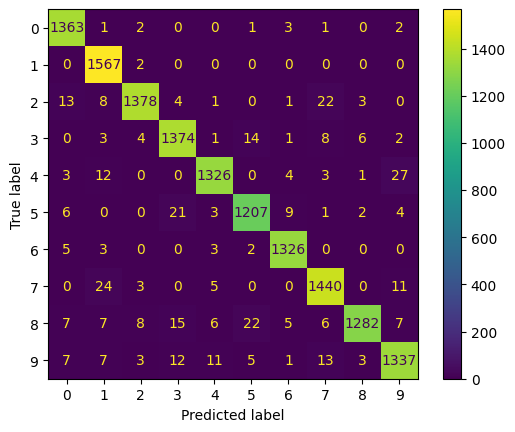

In [21]:
run.plot(plot_confusion_matrix,['KNN'])

## Brincando com nossos números

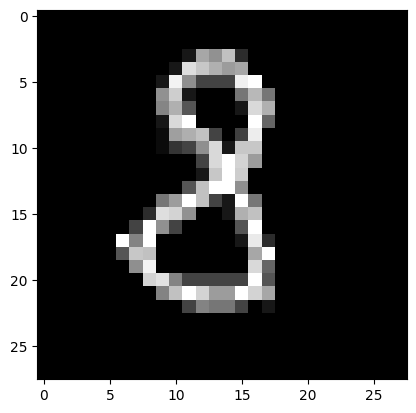

array([3])

In [27]:
# Testando número
num = Num('imgs/oito.png', invert=True)
num.plot()
run.models['KNN'].predict(num.to_array())